In [ ]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import scanpy.external as sce

In [5]:
import anndata

In [6]:
import h5py

#### Load data

In [13]:
adata = sc.read(os.path.join(data_dir, 'breast_tumor.h5ad'))

#### QC

In [21]:
adata = adata[adata.obs.total_counts > 300, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 50000, :]

#### Train model

In [36]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch", labels_key='celltype_minor_wu')

In [37]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [38]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 18/18: 100%|██████████| 18/18 [13:09<00:00, 43.89s/it, loss=3.94e+03, v_num=1]


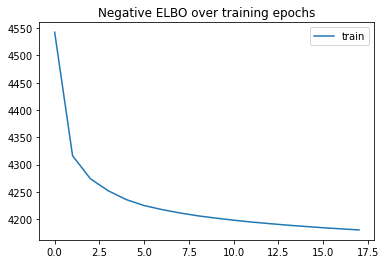

In [39]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [40]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    unlabeled_category="Unknown",
)

In [41]:
lvae.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 25/25: 100%|██████████| 25/25 [40:27<00:00, 97.10s/it, loss=4.28e+03, v_num=1] 


In [ ]:
plt.plot(lvae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [42]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)

In [43]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [44]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [45]:
sc.tl.umap(adata)

In [51]:
scanvi_path = 'models/breast_tumor_all_cells_scanvi'

In [23]:
lvae = scvi.model.SCANVI.load(scanvi_path, adata=adata, use_gpu=True)

INFO     File models/glioblastoma_tumor_all_cells_scanvi/model.pt already downloaded         


In [52]:
adata.obs["C_scANVI"] = lvae.predict(adata)

In [53]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

### Lymphoid only

In [16]:
adata_immune = adata[adata.obs['level1'].isin(['Lymphoid', 'Myeloid'])].copy()

In [17]:
adata_immune

AnnData object with n_obs × n_vars = 149783 × 15298
    obs: 'sample', 'patient', 'batch', 'tissue', 'dataset', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'celltype_subset_wu', 'celltype_minor_wu', 'celltype_major_wu', 'celltype_bassez', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'level1'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'celltype_minor_wu_colors', 'dataset_colors', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
#scvi.model.SCVI.setup_anndata(adata_lymphoid, batch_key="batch", labels_key='celltypist_prediction')
scvi.model.SCVI.setup_anndata(adata_immune, batch_key="batch")

In [19]:
vae = scvi.model.SCVI(adata_immune, n_layers=2, n_latent=30, gene_likelihood="nb")

In [20]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 53/53: 100%|██████████| 53/53 [12:43<00:00, 14.40s/it, loss=2.59e+03, v_num=1]


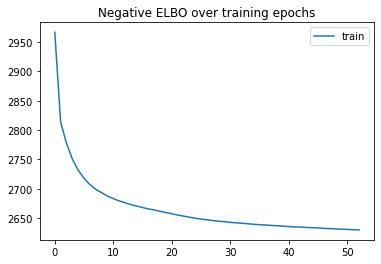

In [21]:
plt.plot(vae.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [22]:
adata_lymphoid.obsm["X_scVI"] = vae.get_latent_representation(adata_lymphoid)

In [23]:
sc.pp.neighbors(adata_lymphoid, use_rep="X_scVI")
sc.tl.umap(adata_lymphoid)

#### Celltypist predication

In [18]:
import celltypist

In [41]:
model = celltypist.models.Model.load(model = 'Immune_All_Low.pkl')

In [19]:
adata_celltypist = adata_immune.copy()

In [20]:
sc.pp.normalize_total(adata_celltypist, target_sum=1e4)
sc.pp.log1p(adata_celltypist)

In [21]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 39005 cells and 15298 genes
🔗 Matching reference genes in the model
🧬 4153 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [22]:
adata_immune.obs['celltypist_prediction'] = predictions.predicted_labels['predicted_labels'][adata_immune.obs.index]#.to_numpy()
adata_immune.obs['celltypist_majority_voting'] = predictions.predicted_labels['majority_voting'][adata_immune.obs.index]#.to_numpy()

In [81]:
adata.obs['level2_cell_type'] = [y if not (x in adata_immune.obs.index) else adata_immune.obs['celltypist_majority_voting'].loc[x] for x,y in zip(adata.obs.index, adata.obs['level2_cell_type'])]

... storing 'level2_cell_type' as categorical


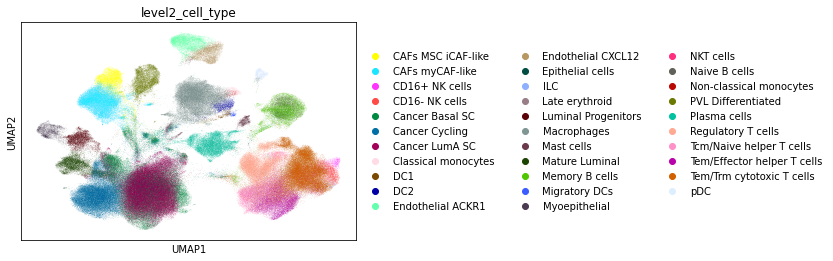

In [55]:
sc.pl.umap(adata, color='level2_cell_type')

In [14]:
adata.write('breast_tumor.h5ad')

#### Sankey

In [22]:
level1_level2_df = sc.get.obs_df(adata,keys=['level1_cell_type', 'level2_cell_type'])
level1_level2_df = pd.crosstab(level1_level2_df['level1_cell_type'], level1_level2_df['level2_cell_type']).T

In [23]:
level2_color_dict = dict(np.array([adata.obs['level2_cell_type'].cat.categories, adata.uns['level2_cell_type_colors']]).T)

In [24]:
level1_color_dict = dict(np.array([adata.obs['level1_cell_type'].cat.categories, adata.uns['level1_cell_type_colors']]).T)

In [25]:
from utils.sankey_diagram import sankey_diagram

In [26]:
order_cell_types = ['Epithelial', 'Mesenchymal', 'Myeloid', 'Lymphoid']

In [27]:
level1_level2_df = level1_level2_df[order_cell_types]

In [28]:
a_sort = list(np.flip(order_cell_types))

In [34]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, a_sort=a_sort, b_sort=b_sort, figsize=(8,12), save_path=os.path.join(figures_dir, 'sankey_level1_level2.pdf'))

/itf-fi-ml/home/hermankn/notebooks/utils/_alluvial.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(alluvial_fan)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


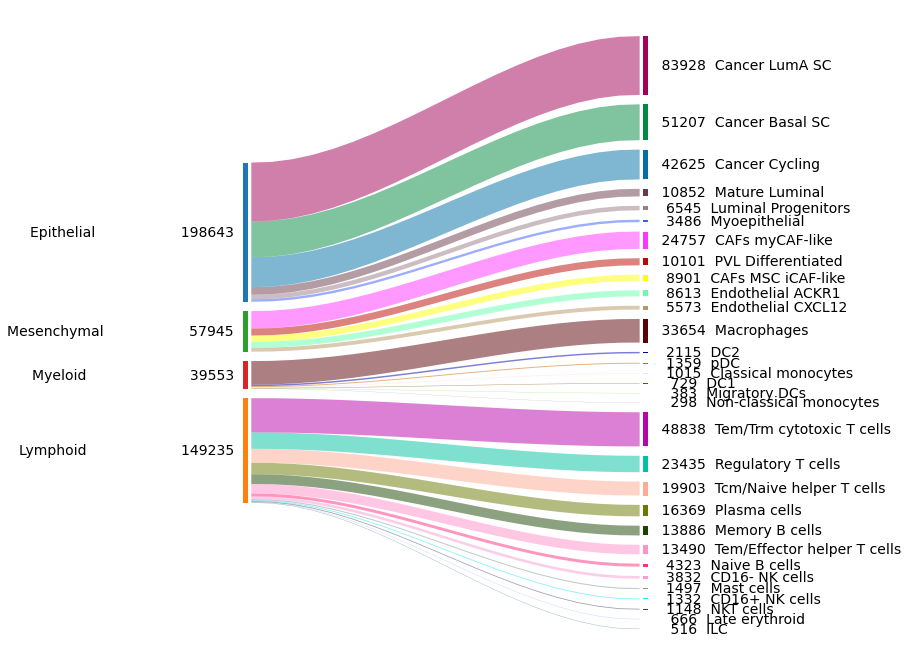

In [30]:
sankey_diagram(adata.obs[['level1_cell_type', 'level2_cell_type']].to_numpy(), level1_color_dict, level2_color_dict, a_sort=a_sort, b_sort=b_sort, figsize=(8,12), show=True)